In [2]:
import mesma 
import rasterio
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from scipy.ndimage import binary_dilation

[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
c:\Users\attic\miniconda3\envs\hls_env\lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


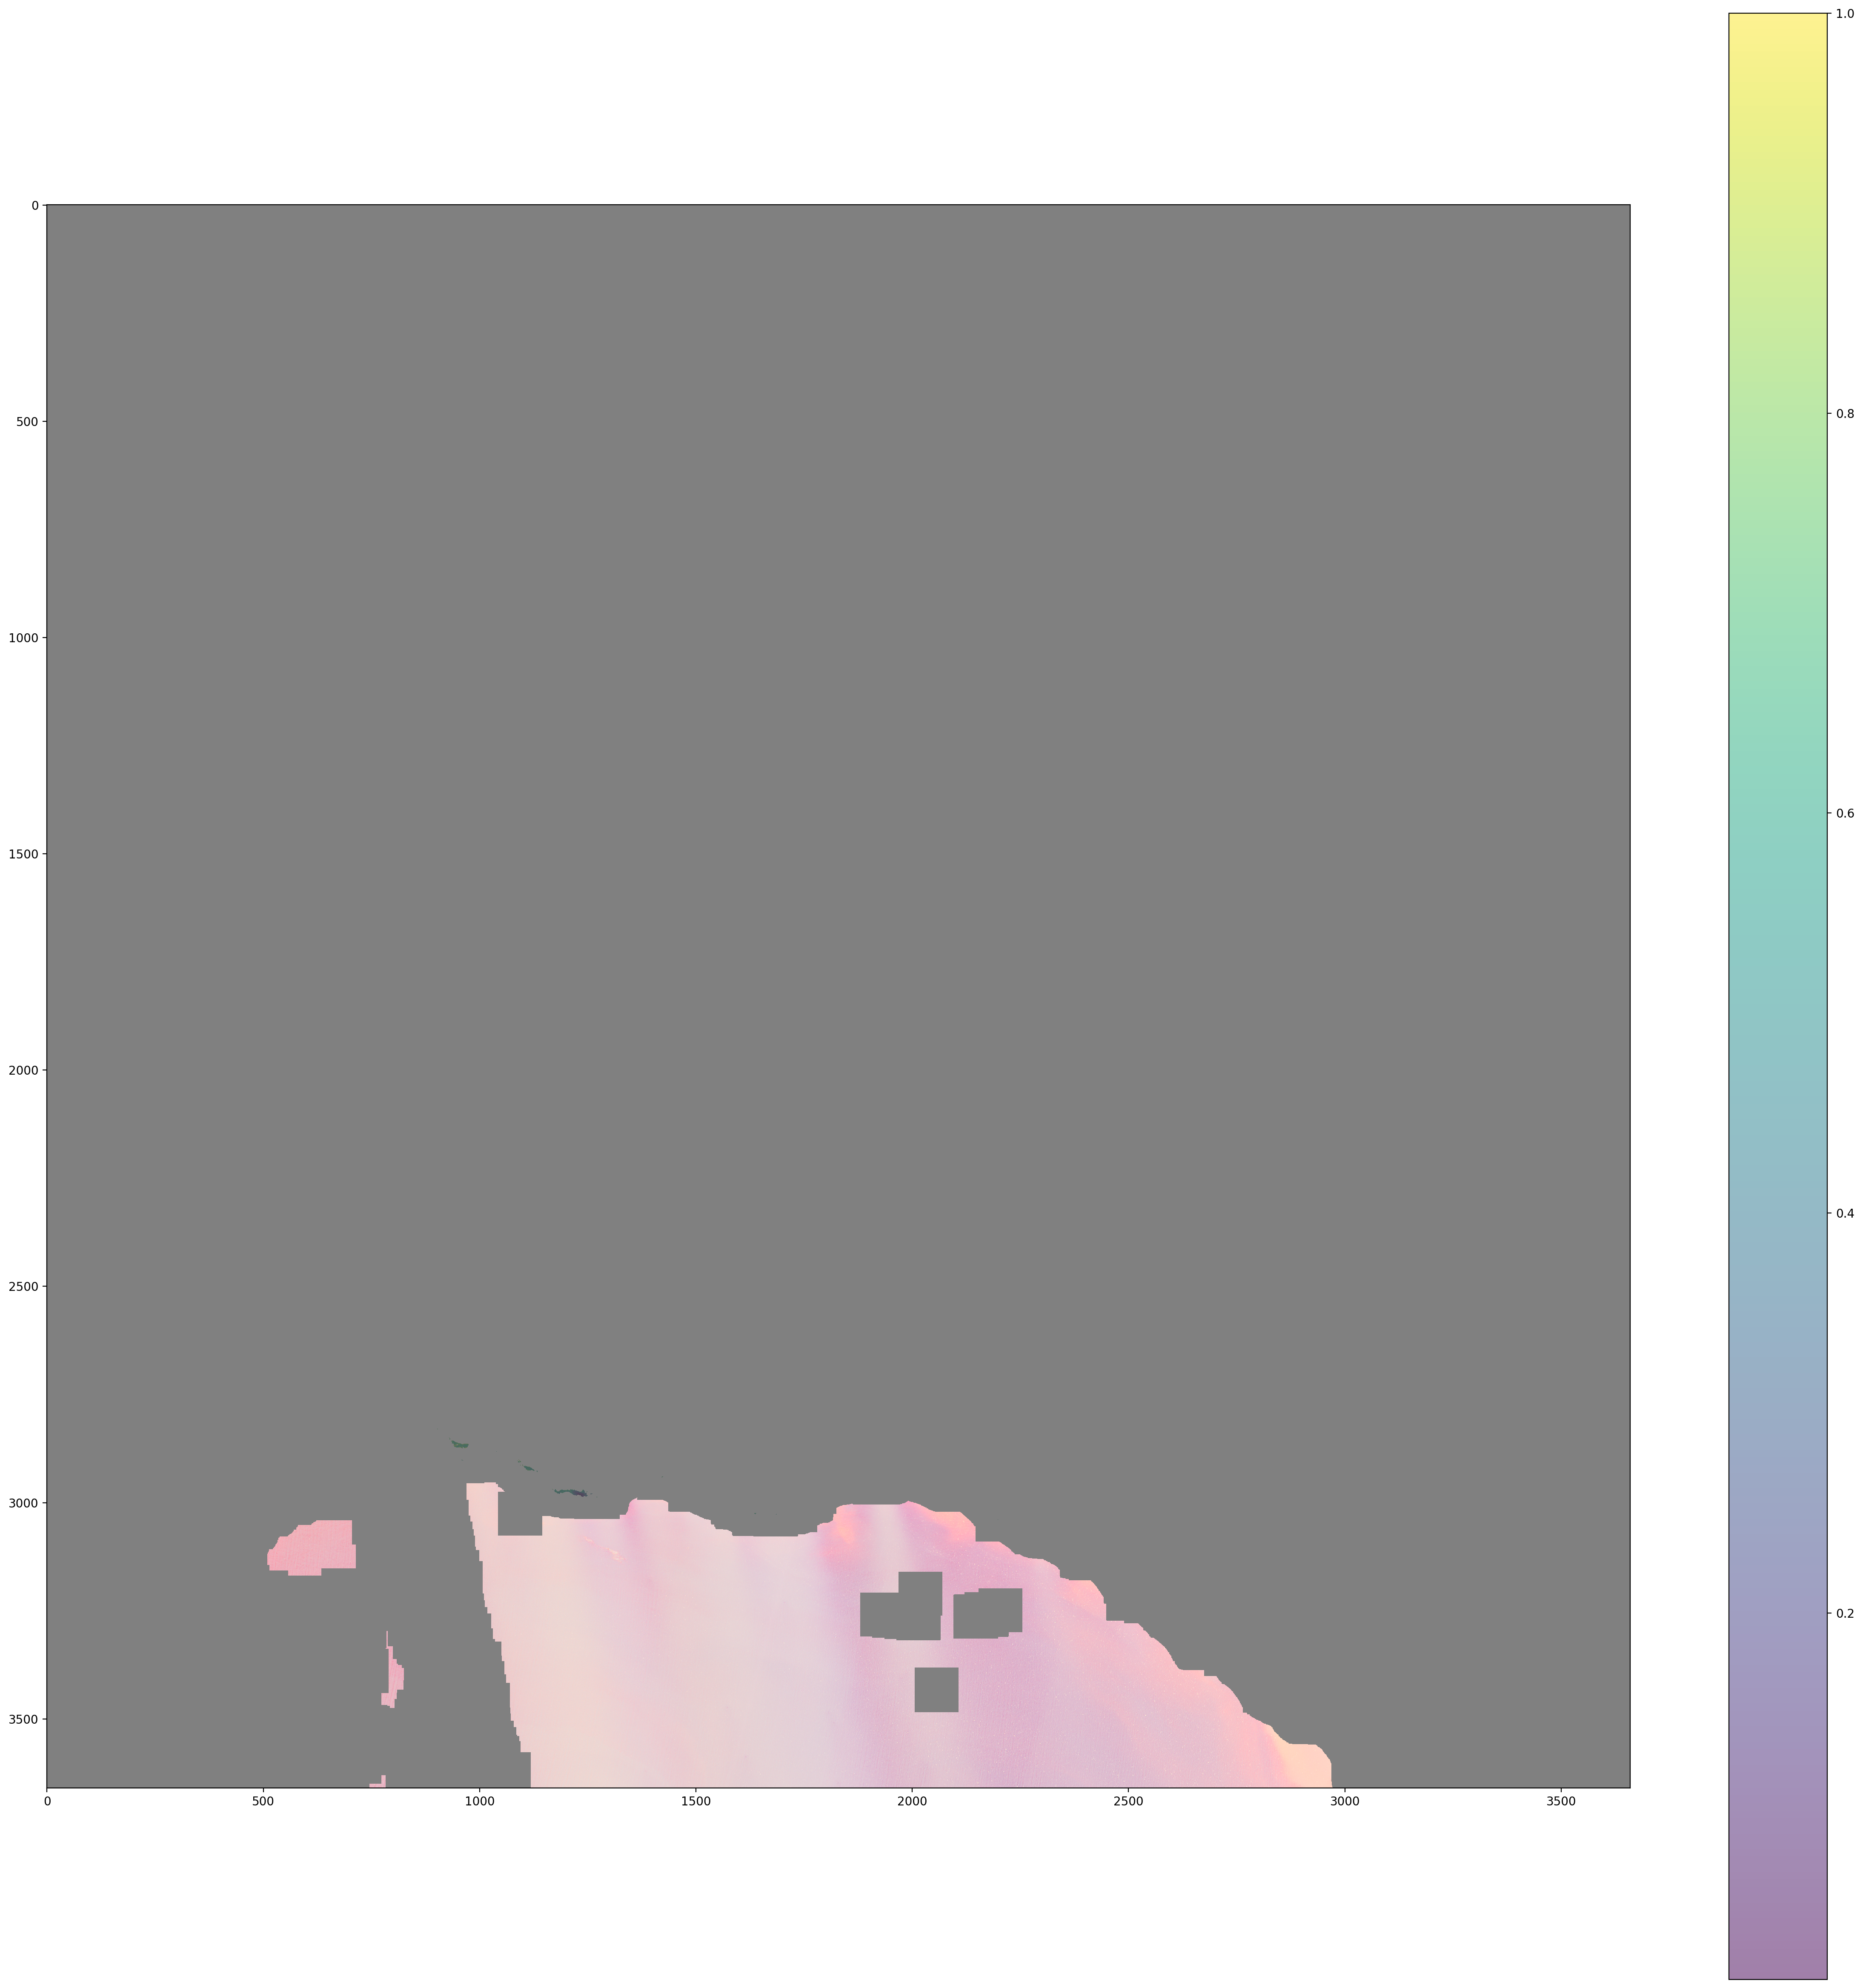

In [19]:
path = r'C:\Users\attic\HLS_Kelp\imagery\rf_training\HLS.L30.T11SKU.2018106T183324.v2.0_kelp_classified.tif'
ocean_dilation = np.ones((100,100)) #Struct for dilation (increase to enlarge non-ocean mask) larger --> takes longer
with rasterio.open(path) as imagery:
    classified_img = imagery.read(7)
    kelp_mask  = []
    ocean_mask = []
    ocean_dilated = np.where(classified_img == 1, False, True)
    ocean_dilated = binary_dilation(ocean_dilated, structure=ocean_dilation) #This takes ~25 seconds. Should look to optimize 
    for i in range(6):
        band_data = imagery.read(i + 1)
        kmask = np.where(classified_img !=0, np.nan, band_data)
        omask = np.where(ocean_dilated == False, band_data, np.nan)
        kelp_mask.append(kmask)
        ocean_mask.append(omask)

    kelp_mask = np.array(kelp_mask)
    ocean_mask = np.array(ocean_mask)
    #print(ocean_mask)

rgb_nor = np.stack([ocean_mask[1]/60,ocean_mask[2]/60,ocean_mask[3]/60], axis=-1)
rgb_nor_cropped = rgb_nor
#print(kelp_mask)
rgb_nor_cropped = np.ma.masked_where(np.isnan(rgb_nor_cropped), rgb_nor_cropped)
image = kelp_mask[1]
plt.figure(figsize=(30, 30), dpi=200)
plt.imshow(image, alpha=.5)
plt.imshow(rgb_nor_cropped, alpha=.5)
plt.colorbar()
plt.show()

In [5]:
ocean_EM = []
Kelp = [459; 556; 437; 1227]
kelp_EM
ocean_EM_n = 0
ocean_data = ocean_mask.reshape(ocean_mask.shape[0], -1)
print(ocean_data.shape)
ocean_data = ocean_data[:, ~np.isnan(ocean_data).any(axis=0)]

for i in range(30):
     index = random.randint(0,len(ocean_data[0])-1)
     ocean_EM.append(ocean_data[:,index])
print(ocean_EM)

    


SyntaxError: invalid syntax (2904508226.py, line 2)

In [1]:
help(mesma)
mesma
help(execute)

NameError: name 'mesma' is not defined